In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor 
import joblib


import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Carregar o dataset preprocessado do Notebook 1
df = pd.read_csv(r'dataset_final.csv')

In [3]:
TARGET = 'QT_VENDA_BRUTO'
features = df.drop(columns=[TARGET])
target = df[TARGET]

In [4]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [5]:
# Lista de modelos a serem testados
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Machine': SVR()
}

In [6]:
# Avaliar cada modelo
results = []

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for model_name, model in models.items():
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Armazenar os resultados
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'MAPE': mape
    })


R² (Coeficiente de Determinação):

Mede a proporção da variância no target que o modelo explica. É útil para entender a qualidade geral do modelo.
Um valor próximo de 1 indica um modelo que explica bem os dados; próximo de 0 indica fraca explicação.
É a métrica principal para avaliar a capacidade do modelo de capturar padrões complexos.
MSE (Mean Squared Error):

Calcula o erro quadrático médio. Penaliza erros maiores de forma mais severa devido à elevação ao quadrado.
Útil para modelos onde grandes desvios são mais impactantes.
MAE (Mean Absolute Error):

Mede o erro absoluto médio, ou seja, a média das diferenças absolutas entre os valores reais e preditos.
É menos sensível a outliers em comparação com o MSE.
RMSE (Root Mean Squared Error):

É a raiz quadrada do MSE e mantém a unidade da variável de saída, facilitando a interpretação.
É especialmente útil em cenários onde queremos avaliar os desvios absolutos médios em termos reais.
MAPE (Mean Absolute Percentage Error):

Calcula o erro percentual médio.
É mais interpretável para não-especialistas, mas pode ser sensível a valores reais próximos de zero.

In [7]:
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAE', ascending=True)
print("Resultados dos modelos:")
results_df

Resultados dos modelos:


,Model,MSE,RMSE,MAE,R^2,MAPE
0,Random Forest,2.494685e+04,157.945703,38.173416,0.999811,0.701291
6,Decision Tree,6.603442e+04,256.971638,78.070382,0.999499,1.205391
4,CatBoost,2.775007e+04,166.583511,87.179631,0.999790,3.139619
3,XGBoost,5.380773e+04,231.964943,109.411838,0.999592,2.838222
1,Gradient Boosting,4.803744e+05,693.090477,342.225357,0.996356,12.538198
5,Linear Regression,1.136167e+07,3370.707159,2036.498883,0.913815,151.212777
2,AdaBoost,9.746939e+06,3122.008873,2377.885397,0.926064,158.874443
7,Support Vector Machine,1.602267e+08,12658.069802,6755.690322,-0.215408,239.606658


MAE --> Escolhido como métrica principal para seleção do modelo devido à robustez frente a variações extremas

In [8]:
# Selecionar o melhor modelo com base no R^2
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

A abordagem adotada para a modelagem focou em testar múltiplos modelos de aprendizado de máquina, com destaque para os métodos de ensemble (Random Forest, Gradient Boosting, AdaBoost, XGBoost e CatBoost). Esses modelos são conhecidos por sua robustez e capacidade de capturar relações complexas nos dados. Além disso, foram testados modelos de baseline, como regressão linear e árvores de decisão, para comparação de desempenho. A inclusão de um Support Vector Regressor (SVR) também buscou avaliar o impacto de métodos baseados em margens.

A escolha por esses modelos permite balancear eficiência computacional e capacidade preditiva, garantindo que características importantes dos dados, como relações não lineares e interações entre variáveis, sejam bem representadas.

In [9]:
best_model_name

'Random Forest'

#### Tunning 

In [10]:
# Configuração para o GridSearchCV
param_grids = {
    'n_estimators': [50, 100, 150],  # Ajuste em uma gama maior de árvores
    'max_depth': [10, 25, 50],  # Testar profundidade maior
    'min_samples_split': [2, 5, 10],  # Mais opções para dividir
    'min_samples_leaf': [1, 4, 10],  # Aumentar os valores de leaf
    'max_features': ['auto', 'sqrt'],  # Testar diferentes abordagens para selecionar as features
}

# Configuração de KFold
kf = KFold(n_splits=2, shuffle=True, random_state=42)  # Usando 2 folds para validação cruzada

# GridSearchCV com KFold e paralelização 
grid = GridSearchCV(best_model, param_grids, cv=kf, scoring='neg_mean_absolute_error')

# Ajuste do modelo
grid.fit(X_train, y_train)

# Recuperando o melhor modelo e seus parâmetros
best_model = grid.best_estimator_
print(f"Melhores hiperparâmetros: {grid.best_params_}")

# Salvando o modelo treinado
joblib.dump(best_model, 'best_model.pkl')


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
162 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 436, in _validate_params
    validate

Melhores hiperparâmetros: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


['best_model.pkl']

In [11]:
# Avaliar o melhor modelo nos dados de teste
final_y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_y_pred)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_y_pred)
final_r2 = r2_score(y_test, final_y_pred)
final_mape = mean_absolute_percentage_error(y_test, final_y_pred)

print("\nAvaliação do Melhor Modelo:")
print(f"Modelo: {best_model_name}")
print(f"MSE: {final_mse}")
print(f"RMSE: {final_rmse}")
print(f"MAE: {final_mae}")
print(f"R^2: {final_r2}")
print(f"MAPE: {final_mape}")



Avaliação do Melhor Modelo:
Modelo: Random Forest
MSE: 427707.7359993059
RMSE: 653.9936819261375
MAE: 256.97394882254616
R^2: 0.9967556001905039
MAPE: 5.1138419123354675


In [12]:
# Justificativa da abordagem
justification = """
A escolha de múltiplos modelos, incluindo métodos de ensemble como Random Forest, Gradient Boosting, XGBoost e CatBoost, visa explorar a capacidade de captura de padrões complexos. 
A métrica R² foi priorizada por medir a proporção de variação explicada pelo modelo, enquanto MSE e RMSE avaliam a magnitude do erro com maior penalização para desvios maiores. 
O MAE complementa, oferecendo uma visão menos sensível a outliers. O MAPE foi incluído para analisar erros relativos, especialmente útil para avaliar previsões em relação aos valores reais quando estes não são próximos de zero. 
O GridSearchCV foi utilizado para refinar hiperparâmetros do melhor modelo, garantindo um desempenho otimizado.
"""
print("\nJustificativa da Abordagem:")
print(justification)



Justificativa da Abordagem:

A escolha de múltiplos modelos, incluindo métodos de ensemble como Random Forest, Gradient Boosting, XGBoost e CatBoost, visa explorar a capacidade de captura de padrões complexos. 
A métrica R² foi priorizada por medir a proporção de variação explicada pelo modelo, enquanto MSE e RMSE avaliam a magnitude do erro com maior penalização para desvios maiores. 
O MAE complementa, oferecendo uma visão menos sensível a outliers. O MAPE foi incluído para analisar erros relativos, especialmente útil para avaliar previsões em relação aos valores reais quando estes não são próximos de zero. 
O GridSearchCV foi utilizado para refinar hiperparâmetros do melhor modelo, garantindo um desempenho otimizado.



#### Gráficos

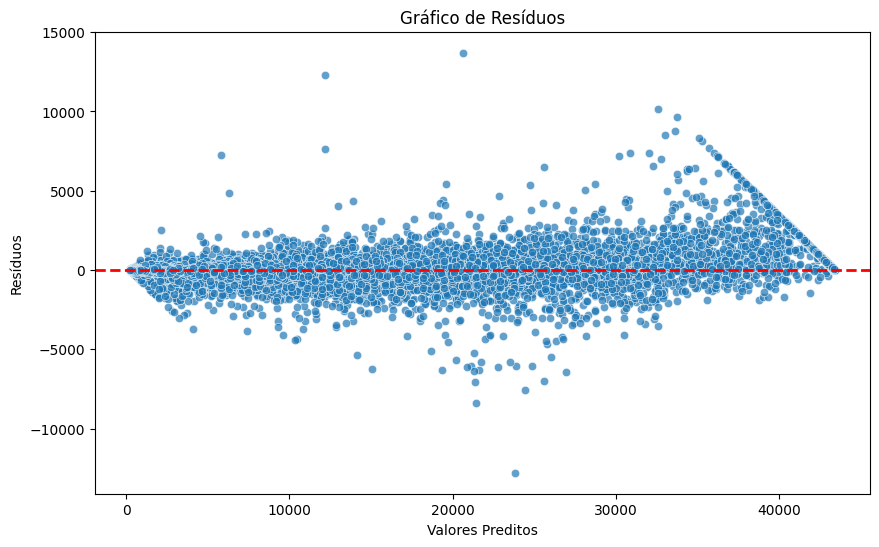

In [15]:
# Cálculo dos resíduos
residuos = y_test - final_y_pred

# Gráfico de Resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=final_y_pred, y=residuos, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Gráfico de Resíduos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.show()



Distribuição dos resíduos:

Os resíduos estão espalhados em torno da linha vermelha (valor 0).
Isso é desejável, pois indica que os erros estão distribuídos de forma aproximadamente uniforme, sem viés óbvio.
Padrão dos resíduos:

Observa-se uma forma triangular, onde os resíduos têm maior variação (dispersão) para valores preditos mais altos.
Isso pode indicar heterocedasticidade, ou seja, a variância dos resíduos não é constante em diferentes níveis de valores preditos.
Outliers:

Existem alguns pontos bastante afastados, indicando potenciais outliers ou previsões com erros significativos.
Possíveis problemas:

A heterocedasticidade sugere que o modelo pode não estar capturando adequadamente a variância dos dados para valores maiores.
Isso pode ser causado por:
Um modelo inadequado ou subajustado para os dados.
Transformações dos dados que não foram realizadas (ex.: escala logarítmica para lidar com variáveis com ampla faixa de valores).

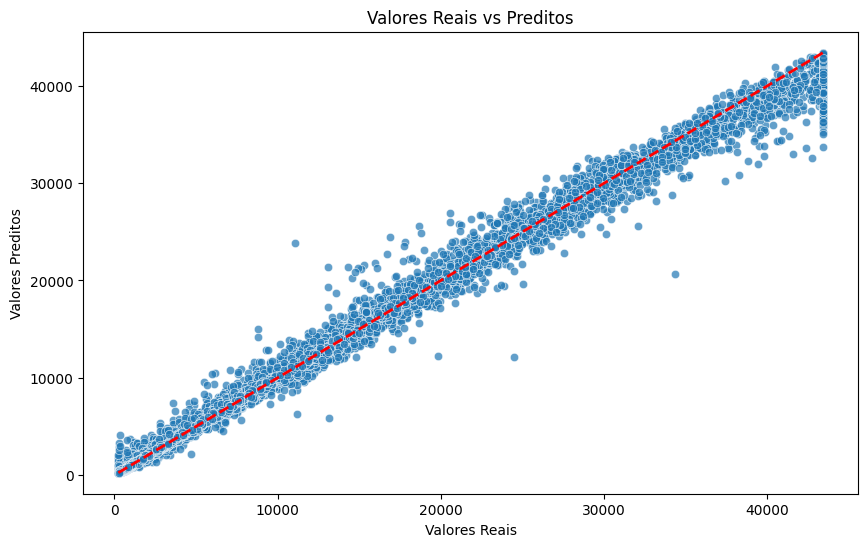

In [16]:
# Gráfico Valores Reais vs Preditos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=final_y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("Valores Reais vs Preditos")
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.show()

Interpretação do gráfico
Distribuição dos pontos:

Os pontos estão alinhados ao longo da linha vermelha, que representa a situação ideal onde os valores preditos são iguais aos valores reais (y = x).
Isso indica que o modelo está, no geral, realizando boas previsões.
Precisão do modelo:

Quanto mais próximos os pontos estiverem da linha vermelha, melhor o modelo. Neste gráfico, os pontos apresentam uma dispersão relativamente pequena, sugerindo bom desempenho.
A presença de alguns pontos mais afastados indica erros em previsões específicas (possíveis outliers).
Tendência ou viés:

Não parece haver uma tendência clara de sub ou superestimação sistemática, o que é positivo.
Erros em valores extremos:

Para valores altos de y_test, observa-se uma leve dispersão, indicando que o modelo pode ter mais dificuldade de prever adequadamente esses valores.

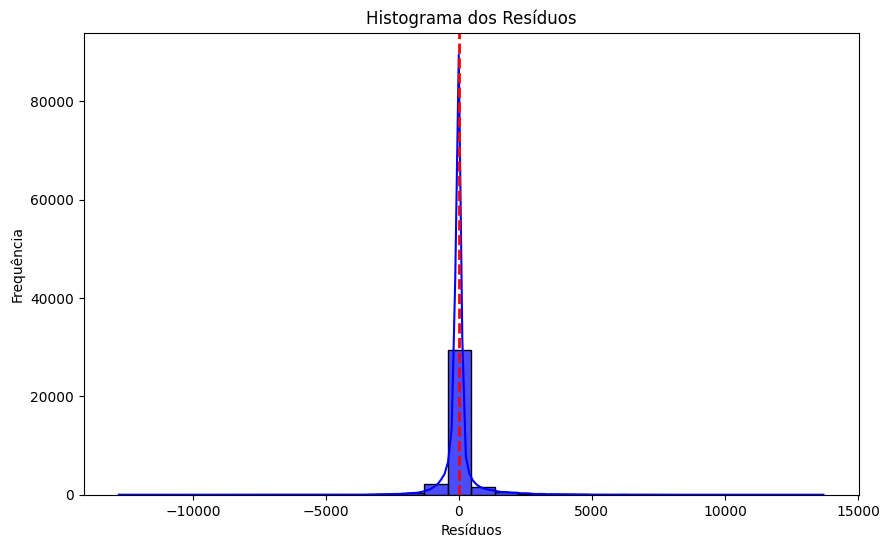

In [17]:
# Histograma dos Resíduos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title("Histograma dos Resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

Interpretação do histograma
Distribuição centralizada:

A maioria dos resíduos está concentrada em torno de 0, indicando que o modelo não apresenta um viés claro em superestimar ou subestimar os valores.
Simetria:

A forma do histograma é aproximadamente simétrica, o que sugere que os erros do modelo podem estar distribuídos de forma equilibrada, sem grandes desvios positivos ou negativos.
Forma da distribuição:

Embora pareça seguir um padrão próximo do normal, há uma leve concentração excessiva de resíduos exatamente em 0 e a presença de caudas longas (valores extremos), especialmente na direção positiva. Isso pode indicar:
Outliers nos dados.
Heterocedasticidade, como observado no gráfico de resíduos anterior.
Outliers:

Resíduos com valores muito altos ou muito baixos (nas caudas) devem ser investigados. Eles podem estar associados a erros de previsão em casos extremos.